# Analyzing iMessage Data

In [1]:
# Import packages and set plot theme:
import sqlite3
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
conn = sqlite3.connect('/Users/mbp/Documents/Side-Projects/iMessage_Analysis/chat.db') # connect to db
cur = conn.cursor() # create cursor object to query db using sql syntax

# get the names of the tables in the database
cur.execute(" select name from sqlite_master where type = 'table' ") 
for name in cur.fetchall():
    print(name)

('_SqliteDatabaseProperties',)
('deleted_messages',)
('sqlite_sequence',)
('chat_handle_join',)
('sync_deleted_messages',)
('message_processing_task',)
('handle',)
('sync_deleted_chats',)
('message_attachment_join',)
('sync_deleted_attachments',)
('kvtable',)
('chat_message_join',)
('message',)
('chat',)
('attachment',)
('sqlite_stat1',)


## Prepare data from relevant tables:

In [3]:
messages = pd.read_sql_query('''select *, datetime(date/1000000000 + strftime("%s", "2001-01-01") ,"unixepoch","localtime")  as date_utc from message''', conn) 

handles = pd.read_sql_query("select * from handle", conn)
chat_message_joins = pd.read_sql_query("select * from chat_message_join", conn)

In [4]:
messages['message_date'] = messages['date']
messages['timestamp'] = messages['date_utc'].apply(lambda x: pd.Timestamp(x))
messages['date'] = messages['timestamp'].apply(lambda x: x.date())
messages['month'] = messages['timestamp'].apply(lambda x: int(x.month))
messages['year'] = messages['timestamp'].apply(lambda x: int(x.year))


# rename the ROWID into message_id, because that's what it is
messages.rename(columns={'ROWID' : 'message_id'}, inplace = True)

# rename appropriately the handle and apple_id/phone_number as well
handles.rename(columns={'id' : 'phone_number', 'ROWID': 'handle_id'}, inplace = True)

In [5]:
# merge the messages with the handles
merge_level_1 = pd.merge(messages[['text', 'handle_id', 'date','message_date' ,'timestamp', 'month','year','is_sent', 'message_id']],  handles[['handle_id', 'phone_number']], on ='handle_id', how='left')

# and then that table with the chats
df_messages = pd.merge(merge_level_1, chat_message_joins[['chat_id', 'message_id']], on = 'message_id', how='left')


print(len(df_messages))
#print(df_messages.head())

131249


## Write to CSV

In [6]:
# Save data for future use:
df_messages.to_csv('/Users/mbp/Documents/Side-Projects/iMessage_Analysis/imessage_data.csv', index = False, encoding = 'utf-8')

## Data exploration

In [7]:
df_messages['date'].min(), df_messages['date'].max()

(datetime.date(2018, 5, 15), datetime.date(2020, 9, 8))

In [8]:
df_messages.head()

,text,handle_id,date,message_date,timestamp,month,year,is_sent,message_id,phone_number,chat_id
0,test,1,2018-05-15,548124178295907264,2018-05-15 20:42:58,5,2018,1,1,+16319651611,1.0
1,Test,1,2018-05-15,548124215222080704,2018-05-15 20:43:35,5,2018,0,2,+16319651611,1.0
2,Tomorrow’s Ramadan,1,2018-05-15,548124223301824320,2018-05-15 20:43:43,5,2018,0,3,+16319651611,1.0
3,LET THE FASTING BEGIN.,1,2018-05-15,548124237825990656,2018-05-15 20:43:57,5,2018,0,4,+16319651611,1.0
4,What do I come up as? My email address?,1,2018-05-15,548124250580835840,2018-05-15 20:44:10,5,2018,1,5,+16319651611,1.0


In [9]:
df_messages.columns

Index(['text', 'handle_id', 'date', 'message_date', 'timestamp', 'month',
       'year', 'is_sent', 'message_id', 'phone_number', 'chat_id'],
      dtype='object')

(array([736846., 736876., 736907., 736938., 736968., 736999., 737029.,
        737060.]),
 <a list of 8 Text xticklabel objects>)

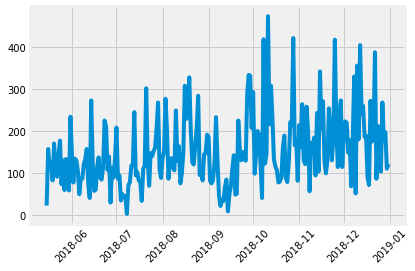

In [10]:
# number of messages per day
plt.plot(df_messages[df_messages['year']==2018].groupby('date').size())
plt.xticks(rotation='45')

<BarContainer object of 12 artists>

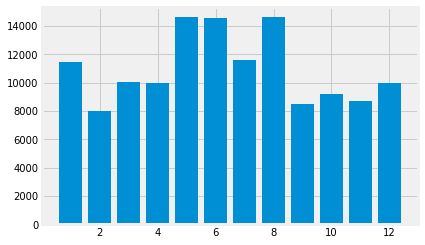

In [11]:
plt.bar(x=sorted(df_messages.month.unique()), height = df_messages.groupby('month').size())

In [12]:
# number of messages per month and year
df_messages.groupby('month').size()
df_messages.groupby('year').size()

year
2018    35127
2019    55586
2020    40536
dtype: int64

In [13]:
# how many messages sent versus received
df_messages.groupby('is_sent').size()

is_sent
0    76560
1    54689
dtype: int64

## Extract group chat data for analysis

In [14]:
# Extract group chat:
greece_gang = df_messages[df_messages['chat_id']==242]

In [15]:
greece_gang

,text,handle_id,date,message_date,timestamp,month,year,is_sent,message_id,phone_number,chat_id
57995,GREECE GANG,17,2019-05-11,579286021128020096,2019-05-11 12:47:01,5,2019,0,57965,+12013628265,242.0
57996,Call me Zeus bitch,0,2019-05-11,579286031763266560,2019-05-11 12:47:11,5,2019,1,57966,NaN,242.0
57997,AYYYYYY,217,2019-05-11,579286039313524480,2019-05-11 12:47:19,5,2019,0,57967,+15167615901,242.0
57998,GANG GANG,16,2019-05-11,579286048375630080,2019-05-11 12:47:28,5,2019,0,57968,+19145732476,242.0
57999,FUCKING LOVE YOU GUYS,16,2019-05-11,579286051493603200,2019-05-11 12:47:31,5,2019,0,57969,+19145732476,242.0
...,...,...,...,...,...,...,...,...,...,...,...
131241,http://www.rsdb.org/full,0,2020-09-08,621287527025999744,2020-09-08 15:52:07,9,2020,1,131478,NaN,242.0
131242,“Racial slur of the day”,17,2020-09-08,621287569653319552,2020-09-08 15:52:49,9,2020,0,131479,+12013628265,242.0
131243,What the farm,17,2020-09-08,621287572889921152,2020-09-08 15:52:52,9,2020,0,131480,+12013628265,242.0
131244,"Right, I thought the same",0,2020-09-08,621287591915999872,2020-09-08 15:53:11,9,2020,1,131481,NaN,242.0


In [16]:
greece_gang.shape

(9714, 11)

In [17]:
greece_gang['date'].min(), greece_gang['date'].max()

(datetime.date(2019, 5, 11), datetime.date(2020, 9, 8))

In [18]:
greece_gang.phone_number.unique()

array(['+12013628265', nan, '+15167615901', '+19145732476',
       '+16318356582', '+19142400741', 'chris.e.pimentel@gmail.com'],
      dtype=object)

In [19]:
# Match phone numbers to names. Eli had multiple phone numbers and email adresses. 
# I will use his current number as his main, and others as "eli other". I also had an "nan" which I will label
# as myself (Bilal).
name_lookup = pd.DataFrame({'phone_number': greece_gang.phone_number.unique(),
'name': ['Dan', 'Bilal', 'Christopher', 'Eli', 'Bilal', 'Eli', 'Eli']})

In [20]:
name_lookup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   phone_number  6 non-null      object
 1   name          7 non-null      object
dtypes: object(2)
memory usage: 240.0+ bytes


In [21]:
name_lookup

,phone_number,name
0,+12013628265,Dan
1,NaN,Bilal
2,+15167615901,Christopher
3,+19145732476,Eli
4,+16318356582,Bilal
5,+19142400741,Eli
6,chris.e.pimentel@gmail.com,Eli


In [ ]:
# Merge names to group chat dataframe:
greece_gang = greece_gang.merge(name_lookup, how='left', on = 'phone_number')
greece_gang.head()

In [23]:
# Clean up data frame to only include columns of interest:
greece_gang = greece_gang[['text','date','year','timestamp','name']]

In [24]:
greece_gang.reset_index()

,index,text,date,year,timestamp,name
0,0,GREECE GANG,2019-05-11,2019,2019-05-11 12:47:01,Dan
1,1,Call me Zeus bitch,2019-05-11,2019,2019-05-11 12:47:11,Bilal
2,2,AYYYYYY,2019-05-11,2019,2019-05-11 12:47:19,Christopher
3,3,GANG GANG,2019-05-11,2019,2019-05-11 12:47:28,Eli
4,4,FUCKING LOVE YOU GUYS,2019-05-11,2019,2019-05-11 12:47:31,Eli
...,...,...,...,...,...,...
9709,9709,http://www.rsdb.org/full,2020-09-08,2020,2020-09-08 15:52:07,Bilal
9710,9710,“Racial slur of the day”,2020-09-08,2020,2020-09-08 15:52:49,Dan
9711,9711,What the farm,2020-09-08,2020,2020-09-08 15:52:52,Dan
9712,9712,"Right, I thought the same",2020-09-08,2020,2020-09-08 15:53:11,Bilal


In [25]:
# Write group chata to csv:
greece_gang.to_csv('/Users/mbp/Documents/Side-Projects/iMessage_Analysis/greece_gang.csv')

# Sentiment Analysis

In [38]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package punkt to /Users/mbp/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/mbp/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [42]:
# calculate sentiment scores for each text in group chat:
greece_gang['text'] = greece_gang.text.astype(str)
scores = []
for texts in greece_gang.text:
    tokens = word_tokenize(texts)
    tokens_clean = [word for word in tokens if not word in stopwords.words('english')]
    tokens_sentence = (" ").join(tokens_clean)
    score = analyzer.polarity_scores(tokens_sentence)
    scores.append(score)

In [88]:
tokens_sentence

'How ’ end rsdb , Bilal'

In [66]:
compound_scores = []
for i in range(0,len(scores)):
    compound_scores.append(scores[i]['compound'])

In [70]:
greece_gang['sentiment'] = compound_scores

In [85]:
greece_gang.to_csv('/Users/mbp/Documents/Side-Projects/iMessage_Analysis/greecegang_senti.csv')